In [4]:
from sklearn.decomposition import PCA
# from Data.load import load
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from Architectures.PCA import PCA as PCAModel

In [5]:
# train, test = load("Pre-processed")
groups = {}
for group in tqdm(["CN"],"Opening faster"): # ,"MCI","AD"
    groups[group]=np.load(open(f"Data/{group}.npy","br"))

train = groups["CN"][:1000]
test = groups["CN"][1000:]
train.shape, test.shape

Opening faster: 100%|██████████| 1/1 [00:22<00:00, 22.38s/it]


(1000, 80, 96, 80)

In [7]:
def wnd_from(train,stride=3,wndlen=8):
    windows = []
    for i in range(0,train.shape[1]-wndlen,stride):
        for j in range(0,train.shape[2]-wndlen,stride):
            for k in range(0,train.shape[3]-wndlen,stride):
                for img_idx in range(len(train)):
                    wnd = train[img_idx, i:i+wndlen, j:j+wndlen, k:k+wndlen]
                    windows.append(wnd)

    return np.stack([w.flatten() for w in windows])

wndlen = 4
windows = wnd_from(train[:60],wndlen=wndlen)
windows.shape

(1257360, 64)

In [3]:
pca = PCA(17)
windows1 = pca.fit_transform(np.stack([w.flatten() for w in windows]))
np.sum(pca.explained_variance_ratio_)

NameError: name 'windows' is not defined

In [ ]:
pm_ = PCAModel(train.shape,init_hidden_depth=4, hidden_depth_grow_factor=3,kernel_size=2,num_layers=3)
pm_.train(train)

Interpreted image shape: (80, 96, 80, 1)
Stack shape: (27, 80, 96, 80)
* R^2 in layer 1: 0.99380
  New stack shape: (27, 40, 48, 40, 4)
* R^2 in layer 2: 0.98966
  New stack shape: (27, 20, 24, 20, 12)
* R^2 in layer 3: 0.98595
  New stack shape: (27, 10, 12, 10, 36)
Total R^2: 0.9697105132636284


In [5]:
pm_ = PCAModel(train.shape,init_hidden_depth=4, hidden_depth_grow_factor=3,kernel_size=3,num_layers=4)
pm_.train(train)

Interpreted image shape: (80, 96, 80, 1)
Stack shape: (45, 80, 96, 80)
* R^2 in layer 1: 0.97751
  New stack shape: (45, 39, 47, 39, 4)
* R^2 in layer 2: 0.97308
  New stack shape: (45, 19, 23, 19, 12)
* R^2 in layer 3: 0.97058
  New stack shape: (45, 9, 11, 9, 36)
* R^2 in layer 4: 0.98028
  New stack shape: (45, 4, 5, 4, 108)
Total R^2: 0.9050124031307321


In [6]:
pm_ = PCAModel(train.shape,init_hidden_depth=4, hidden_depth_grow_factor=5,kernel_size=3,num_layers=4)
pm_.train(train)

Interpreted image shape: (80, 96, 80, 1)
Stack shape: (45, 80, 96, 80)
* R^2 in layer 1: 0.97751
  New stack shape: (45, 39, 47, 39, 4)
* R^2 in layer 2: 0.98655
  New stack shape: (45, 19, 23, 19, 20)
* R^2 in layer 3: 0.98781
  New stack shape: (45, 9, 11, 9, 100)
* R^2 in layer 4: 0.99590
  New stack shape: (45, 4, 5, 4, 500)
Total R^2: 0.9487090866088073


In [7]:
pm_ = PCAModel(train.shape,init_hidden_depth=10, hidden_depth_grow_factor=4,kernel_size=3,num_layers=4)
pm_.train(train)

Interpreted image shape: (80, 96, 80, 1)
Stack shape: (45, 80, 96, 80)
* R^2 in layer 1: 0.99227
  New stack shape: (45, 39, 47, 39, 10)
* R^2 in layer 2: 0.98874
  New stack shape: (45, 19, 23, 19, 40)
* R^2 in layer 3: 0.98525
  New stack shape: (45, 9, 11, 9, 160)
* R^2 in layer 4: 0.99484
  New stack shape: (45, 4, 5, 4, 640)
Total R^2: 0.9616371188297177


In [9]:
pm = PCAModel(train.shape,init_hidden_depth=8, hidden_depth_grow_factor=25,kernel_size=4,stride=4,num_layers=2)
pm.train(train)

Interpreted image shape: (80, 96, 80, 1)
Stack shape: (1000, 80, 96, 80)
* R^2 in layer 1: 0.97769
  New stack shape: (1000, 20, 24, 20, 8)
* R^2 in layer 2: 0.98913
  New stack shape: (1000, 5, 6, 5, 200)
Total R^2: 0.9670660909106326


Latent dims: 30000
Compression factor: 0.01591796875


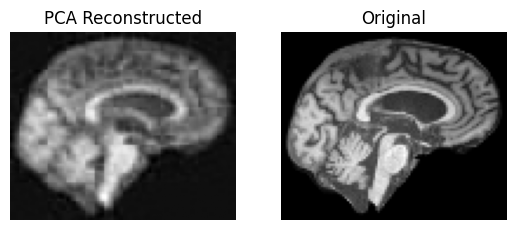

In [11]:
latent = pm.encode(test)
recon = pm.decode(latent)

def imshow_many(ims, titles):
    for i in range(len(ims)):
        plt.subplot(1,len(ims),i+1)
        plt.imshow(np.rot90(ims[i][train.shape[1]//2,:, :]), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')  # Hide axes
imshow_many([recon[0], test[0]], ["PCA Reconstructed","Original"])

print("Latent dims:", np.prod(latent.shape[1:]))
print("Compression factor:", np.prod(latent.shape)/np.prod(train.shape))

In [6]:
pm.save("Trained Models/PCA/30k")

Model saved to Trained Models/PCA/30k


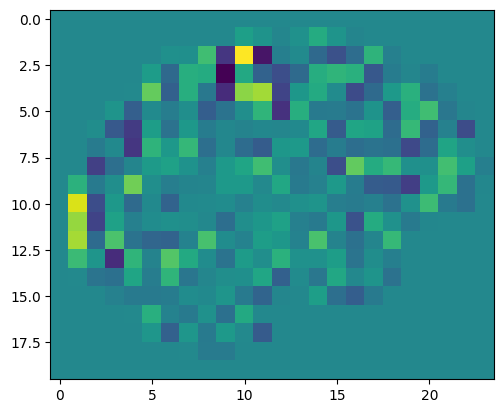

In [38]:
plt.imshow(np.rot90(img_pca[5,:,:,6]))

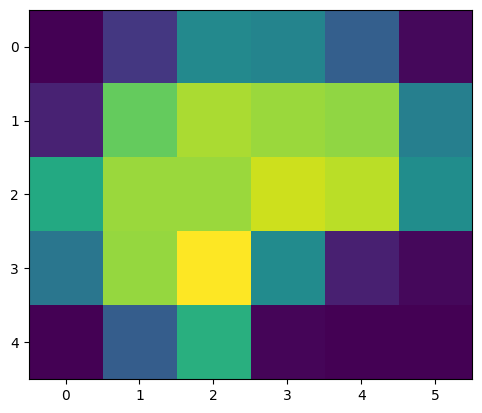

In [41]:
plt.imshow(np.rot90(img_pca1[2,:,:,0]))

In [88]:
from tensorflow.keras import layers, Model, activations

input_shape = list(windows.shape[1:])+[1]
# Encoder
encoder_input = x = layers.Input(shape=input_shape)
x = layers.Conv3D(4, (3, 3, 3), strides=2, activation=activations.leaky_relu, padding="same")(x)
x = layers.Conv3D(10, (3, 3, 3), strides=2, activation=activations.leaky_relu, padding="same")(x)
pre_flatten_shape = x.shape
print(f"Pre-flattened latent shape: {pre_flatten_shape}")
x = layers.Flatten()(x)
encoded = layers.Dense(20, activation="relu")(x)
encoder = Model(encoder_input, encoded, name="encoder")

# Decoder
decoder_input = x = layers.Input(shape=encoded.shape[1:])  # Adjusted latent space shape

# Reshape back to 3D
x = layers.Dense(
    pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4],
    activation="relu"
)(decoder_input)
x = layers.Reshape(pre_flatten_shape[1:])(x)
x = layers.Conv3DTranspose(10, (3, 3, 3),2, activation=activations.leaky_relu, padding="same")(x)
x = layers.Conv3DTranspose(4, (3, 3, 3),2, activation=activations.leaky_relu, padding="same")(x)
decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)
decoder = Model(decoder_input, decoded, name="decoder")

# Full Autoencoder (combine encoder and decoder)
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(encoder_input))
autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

autoencoder.fit(windows,windows,epochs=5,verbose=True,batch_size=64)

Pre-flattened latent shape: (None, 2, 2, 2, 10)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 8, 8, 8, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 20)             │         2,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 8, 8, 8, 1)     │         5,583 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,405 (32.83 KB)

 Trainable params: 8,405 (32.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0109
Epoch 2/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0022
Epoch 3/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0019
Epoch 4/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0019
Epoch 5/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0018


In [92]:
import numpy as np

# Get autoencoder output (reconstructed data)
x_reconstructed = autoencoder.predict(windows)

# Compute total variance of original data
total_variance = np.var(windows)

# Compute reconstruction variance (MSE between x and x_reconstructed)
reconstruction_variance = np.mean((windows - x_reconstructed.reshape(345600,8,8,8)) ** 2)

# Compute retained variance
retained_variance = 1 - (reconstruction_variance / total_variance)

print(f"Retained Variance: {retained_variance:.4f}")


10800/10800 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Retained Variance: 0.9509
